<div style="background-color:rgb(242, 244, 244); padding:10px ;">
Power (minimal detectable effect) analysis for PCAWG drivers paper (Rheinbay, Nielsen, Abascal, Wala, Shapira et al). <br>
Power analyses and code based on Lawrence et al, <i>Nature</i>, 2014. <br>
Esther Rheinbay
<div>

In [1]:
%matplotlib inline
import pandas as pd
#import sys, re, os, math
import numpy as np
from scipy.stats import binom
from scipy.optimize import minimize, root, fsolve
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
#matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.use('Agg')
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.serif'] = ['Arial']
rcParams["font.size"] = "40"


/home/unix/muonweb/muonweb_venv/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# binomial power calculation - translated from Gaddy Getz' original Matlab code
def binopwr(n, p, f, alpha):
    """Power for a one-sided binomial test"""
    cutoff = binom.ppf(1-alpha, n, p)
    pmax = 1-binom.cdf(cutoff-1, n, p)
    w = 1-(pmax-alpha)/binom.pmf(cutoff, n,p)
    pwr = 1-binom.cdf(cutoff, n, f)
    return pwr+w*binom.pmf(cutoff, n, f)

In [3]:
# Patient counts for each cohort
patient_counts = pd.read_csv('tumor_types_patient_counts.txt', sep='\t', low_memory=False, comment="#", header=0)

In [4]:
# Background mutation rates for each cohort element type combination (from Julian Hess)
bmrs = pd.read_csv('cohort-feature_mutation_rates.txt', low_memory=False, sep='\t', comment="#", header=0)
# replace "CA" with "Ca" in cohort names
bmrs["cohort"] = [x.replace("CA", "Ca") for x in bmrs["cohort"]]

# pancancer backround mutation rates (also from Julian Hess)
pancan_rates = pd.read_csv('pancan-no-melanoma-lymph_rates.txt', low_memory=False, sep='\t', comment="#", header=0)
pancan_rates.columns = ['feature', 'rate_95CI_lo', 'rate', 'rate_95CI_hi']
pancan_rates['cohort'] = ['Pancan-no-skin-melanoma-lymph']*len(pancan_rates)

bmrs = bmrs.append(pancan_rates)

# annotate mut_rates with patient_counts - not all cohorts have mutation rates! 
bmrs = bmrs.merge(patient_counts, left_on = "cohort", right_on= "Tumor type")

# drop CNS-Oligo, Cervix-SCC in "new" cohort selection (only keep cohorts with at least 20 cases)
bmrs= bmrs[~(bmrs["cohort"].isin(["Cervix-SCC", "CNS-Oligo"]))]
# remove lncrna promoters
bmrs= bmrs[bmrs["feature"]!= "lncrna.prom"]


/home/unix/muonweb/muonweb_venv/lib/python2.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
# global power variables - see Lawrence et al, 2014 for details
gene_f=1 
desired_power=0.9

In [6]:
# add column for powered driver frequencies to dataframe
bmrs = bmrs.assign(mut_freq=np.nan)

In [7]:
# Solve power equation for log patient event frequency (MDE)
# median element lengths obtained from Morten Muhlig Nielsen

element_stats = pd.read_csv('element_type_stats.txt', sep='\t', low_memory=False,  header=0)

for i, element in element_stats.iterrows():
    
    # Median element length
    L = element.Median_length
    
    # Number of regions
    num_regions = element.Num_regions
    
    # FDR correction
    alpha=0.1/num_regions
    
    # false negative/missed mutation rate, based on average detection sensitivity for each element
    fnr = 1-element.Average_ds
    F=1-fnr

    # For each tumor type
    for ttype in set(bmrs.cohort):
        
        # calculate cohort and elementy-type background mutation frequency
        bmr =  float(bmrs[(bmrs.cohort==ttype) & (bmrs.feature==element.Feature)].rate*1e-6)

        # number of cases
        ns = int(bmrs[(bmrs.feature==element.Feature) & (bmrs.cohort == ttype)]["Number of patients"])
        
        # log of probability of patient not having any mutation in the gene (or element)
        ln_bg_p_0_bino=L*np.log(1-bmr*gene_f);  
        
        # probability of a patient having at least one mutation in the element
        p=1-np.exp(ln_bg_p_0_bino)
        
        # solve for mimimal mutated driver frequency
        # initial value 
        prev = 0.01
        x = minimize(lambda x: (binopwr(ns ,p,(1-(1-p)*(1-F*(x))), alpha)-desired_power)**2, prev, method="Nelder-Mead").x
        bmrs.set_value((bmrs.feature==element.Feature) & (bmrs.cohort == ttype), 'mut_freq', x[0])

   

/home/unix/muonweb/muonweb_venv/lib/python2.7/site-packages/ipykernel_launcher.py:40: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [8]:
# sort results by number of patients
bmrs.sort_values("Number of patients", axis=0, ascending=False, inplace=True)
cohort_ranking = bmrs[(bmrs.feature=="CDS")]["cohort"]

# make minimum mut_freq matrix
mut_freq_df = bmrs.pivot(index='feature', columns='cohort', values='mut_freq')
mut_freq_df = mut_freq_df[cohort_ranking]

# number of patients required for frequency
bmrs['patients_with_mutation'] = bmrs["Number of patients"] * bmrs.mut_freq
mut_freq_df_2 = bmrs.pivot(index='feature', columns='cohort', values='patients_with_mutation')
mut_freq_df_2 = mut_freq_df_2[cohort_ranking]

/home/unix/muonweb/muonweb_venv/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/unix/muonweb/muonweb_venv/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


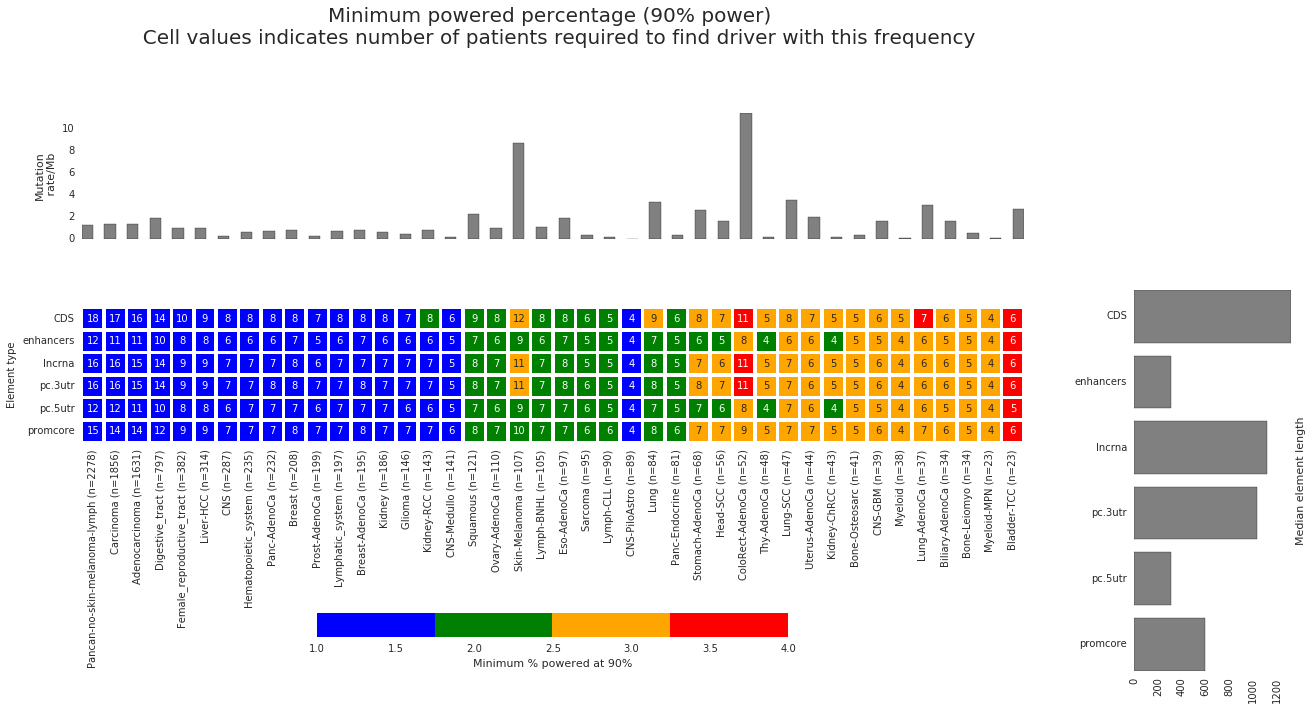

In [9]:
# plot heatmap

# discrete bins for driver percentage for better readability as suggested by reviewer (<5%, 5-10%, 10-20%, >20%)
binned_freq = mut_freq_df*100 
binned_freq[binned_freq<=5]=1
binned_freq[(binned_freq>=5) & (binned_freq<10)]=2
binned_freq[(binned_freq>=10) & (binned_freq<20)]=3
binned_freq[binned_freq>20]=4

sns.set(style="white")
sns.set(font_scale=1)
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
fig = plt.figure(figsize=(60, 10))
gs = gridspec.GridSpec(2, 2,  width_ratios=[6,1], height_ratios=[1, 3])
gs.update(left=0.2, right=0.48)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

ax1.autoscale(tight=True)
ax1.set_axis_bgcolor('white')
ax1.bar(range(len(mut_freq_df_2.columns.values)), bmrs[(bmrs.cohort.isin(mut_freq_df_2.columns.values)) & (bmrs.feature=="CDS")].rate, 0.5, color="grey", align='center', tick_label ="")
ax1.set_ylabel("Mutation\n rate/Mb", fontname="Arial")
ax1.set_title('Minimum powered percentage (90% power) \n  Cell values indicates number of patients required to find driver with this frequency', fontsize=20, y=1.5)    
ax1.spines['left'].set_color('black')

# placeholder/empty plot in upper right corner
ax2.axis('off')

# round required patient number to nearest integer
labels = mut_freq_df_2.applymap(lambda x: int(round(x,0)))

numbers =  map(str, bmrs[(bmrs.cohort.isin(mut_freq_df.columns.values)) & (bmrs.feature=="CDS")]["Number of patients"])

sns.heatmap(binned_freq, cmap=matplotlib.colors.ListedColormap(['blue', 'green', 'orange', 'red']), annot = labels, linewidths=2.5, square=True, cbar_kws= {"orientation": "horizontal", 'label': 'Minimum % powered at 90%', 'shrink':0.5, 'pad':0.45}, annot_kws={"size": 10},  ax=ax3, xticklabels=[mut_freq_df_2.columns.values[i] + " (n=" + numbers[i] + ")" for i in range(len(mut_freq_df_2.columns.values))], vmin=1, vmax=4)
ax3.set_xlabel('', fontsize=30)
ax3.set_ylabel('Element type', fontsize=10)

# element lengths bar graph
ax4.autoscale(tight=True)
ax4.barh( range(len(element_stats)), element_stats.sort_values(by="Feature").Median_length[::-1],  color="grey", align='center', tick_label =element_stats.sort_values(by="Feature").Feature[::-1] )
ax4.set_ylabel("Median element length")  
ax4.yaxis.set_label_position("right")
plt.xticks(rotation='vertical')
ax4.spines['bottom'].set_color('black')
ax4.set_axis_bgcolor('white')

In [10]:
# Power plot for 5% mutation frequency to illustrate formula to find power for different element lengths

# fixed mutation frequency in the population (5%)
mut_rates=[0.05]

# background mutation rate range
bmr_range=[1e-7, 25e-6]

nbmrs=100;
r0s = np.logspace(np.log10(bmr_range[0]),np.log10(bmr_range[1]),nbmrs)

xv2 = np.full((len(r0s), 6), np.nan)

# number of protein-coding genes
num_regions = 20185;

# FDR correction
alpha=0.1/num_regions;

# median average detection sensitivity for pc_cds
fnr = 1-0.9665223;
F=1-fnr;

# List of different lengths
lengths = [100, 500, 1000, 5000, 10000]

for l in range(len(lengths)):

    L=lengths[l]
 
    for mi in range(len(mut_rates)):
        mut_rate=mut_rates[mi]

        prev = np.log(100)
        for i in range(len(r0s)):
            ln_bg_p_0_bino=L*np.log(1-r0s[i]*gene_f)

            # probability of a patient having at least one mutation in the element
            p=1-np.exp(ln_bg_p_0_bino) # prob of a patient having at least one mutation in the element
            f=1-(1-p)*(1-F*mut_rate)

            # solve power equation
            x=minimize(lambda x: (((1-(np.exp(x)-math.floor(np.exp(x))))*binopwr(math.floor(np.exp(x)),p,f,alpha)+ 
                                (np.exp(x)-math.floor(np.exp(x)))*binopwr(math.floor(np.exp(x))+1,p,f,alpha))-desired_power)**2,prev,method="Nelder-Mead").x
            
            xv2[i,l]=np.exp(x)
            prev=x

# make plot
sns.set(style="whitegrid")
plt.rcParams['axes.facecolor'] = 'white'
cols = ['m-', 'r-', 'g-', 'b-', 'orange']

lower_n=50
ymax = 3000

fig, ax = plt.subplots()

for i in range(len(lengths)):
    ax.loglog(r0s, xv2[:,i], cols[i],  markersize=3, label = str(int(lengths[i])) +'bp')

plt.grid(True, which='major', color='k', linestyle=':', linewidth=1)
plt.grid(True, which='minor', color='grey', linestyle=':', linewidth=0.5)

plt.title('Power to detect a driver element with 5% frequency and different lengths')    
ax.set_xlim(bmr_range)
ax.set_ylim([lower_n, ymax])
ax.set_xlabel('Somatic mutation frequency (/Mb)')
ax.set_ylabel('Number of patients needed for ' + str(int(desired_power*100)) + '% power')
plt.xticks(1e-6*np.array([0.1, 0.5, 1, 5, 10, 20]), [0.1, 0.5, 1, 5, 10, 20])
ax.legend(loc='upper left')

# add vertical lines to indicate equivalent power for L1 and L2 (see below)
# Given l=500bp and bmr=1e6, equivalent bmr for l2=5000bp is 1e-7.
# Number of patients needed for frequency of 5%, element of length 500 bp and BMR of 1e-6: 133.377202026
# Number of patients needed for frequency of 5%, element of length 5000 bp and BMR of 1e-7: 132.932813997

# number of patients for L1 = 500, f1 = 5e-6
prev = np.log(100)
ln_bg_p_0_bino=500*np.log(1-5e-6*gene_f)
p=1-np.exp(ln_bg_p_0_bino) 
f=1-(1-p)*(1-F*mut_rate)
x_L1=np.exp(minimize(lambda x: (((1-(np.exp(x)-math.floor(np.exp(x))))*binopwr(math.floor(np.exp(x)),p,f,alpha)+ 
                                (np.exp(x)-math.floor(np.exp(x)))*binopwr(math.floor(np.exp(x))+1,p,f,alpha))-desired_power)**2,prev,method="Nelder-Mead").x)

        
# number of patients for L5 = 5000, f1 = 5e-7
prev = np.log(100)
ln_bg_p_0_bino=5000*np.log(1-5e-7*gene_f)
p=1-np.exp(ln_bg_p_0_bino) # prob of a patient having at least one mutation in the element
f=1-(1-p)*(1-F*mut_rate)
x_L2=np.exp(minimize(lambda x: (((1-(np.exp(x)-math.floor(np.exp(x))))*binopwr(math.floor(np.exp(x)),p,f,alpha)+ 
                                (np.exp(x)-math.floor(np.exp(x)))*binopwr(math.floor(np.exp(x))+1,p,f,alpha))-desired_power)**2,prev,method="Nelder-Mead").x)
 

plt.plot([5e-6, 5e-7], [x_L1, x_L2], color='k', linewidth=2)    
plt.plot([5e-6, 5e-7], [x_L1, x_L2], color='k', marker='*', markersize=10)

NameError: global name 'math' is not defined

In [ ]:
# power plot for different mutation frequencies and element lengths for Supplementary Note 10
# background mutation rate range
mut_rates=[0.01, 0.02, 0.05, 0.1 ,0.2]
bmr_range=[1e-7, 25e-6]
nbmrs=100;
r0s = np.logspace(np.log10(bmr_range[0]),np.log10(bmr_range[1]),nbmrs)

xv2 = np.full((len(r0s), 6), np.nan)

# number of protein-coding genes
num_regions = 20185;

# FDR correction
alpha=0.1/num_regions;

# median average detection sensitivity for pc_cds
fnr = 1-0.9665223;
F=1-fnr;

# List of different lengths
lengths = [100, 500, 1000, 5000, 10000]

# plot params
sns.set(style="whitegrid")
plt.rcParams['axes.facecolor'] = 'white'
cols = ['m-', 'r-', 'g-', 'b-', 'orange']
ymin = 10
ymax = 10000

# make plot
fig, ax = plt.subplots(1,5, figsize=(20,4), sharey=False)

for mr in range(len(mut_rates)):    
    for l in range(len(lengths)):

        L=lengths[l]

        # fake loop to preserve functionality of code
        for mi in range(1):
            
            mut_rate=mut_rates[mr]

            prev = np.log(100)
            for i in range(len(r0s)):
                ln_bg_p_0_bino=L*np.log(1-r0s[i]*gene_f)

                # prob of a patient having at least one mutation in the element
                p=1-np.exp(ln_bg_p_0_bino) 
                f=1-(1-p)*(1-F*mut_rate)
                

                x=minimize(lambda x: (((1-(np.exp(x)-math.floor(np.exp(x))))*binopwr(math.floor(np.exp(x)),p,f,alpha)+ 
                                    (np.exp(x)-math.floor(np.exp(x)))*binopwr(math.floor(np.exp(x))+1,p,f,alpha))-desired_power)**2,prev,method="Nelder-Mead").x
                xv2[i,l]=np.exp(x)
                prev=x

    for i in range(len(lengths)):
        ax[mr].loglog(r0s, xv2[:,i], cols[i],  markersize=3, label = str(int(lengths[i])) +'bp')

    ax[mr].grid(True, which='major', color='k', linestyle=':', linewidth=1)
    ax[mr].grid(True, which='minor', color='grey', linestyle=':', linewidth=0.5)

    ax[mr].set_title(str(round(mut_rate * 100, 0)) + '% frequency')    
    ax[mr].set_xlim(bmr_range)
    ax[mr].set_xlabel('Somatic mutation frequency (/Mb)')
    
    # note that Python ranges are defined as [min, max)
    ax[mr].set_xticks(1e-6*np.array([0.1, 0.5, 1, 5, 10, 20]))
    ax[mr].set_xticklabels([0.1, 0.5, 1, 5, 10, 20])
    if mr==0:
        ax[mr].legend(loc='lower left')
        ax[mr].set_ylabel('Number of patients needed for ' + str(int(desired_power*100)) + '% power')
    ax[mr].set_ylim([ymin, ymax])